# Introduction

Object detection is one of the challenging tasks in computer vision, in this project we use a Regional Convolutional Neural Network (RCNN), to identify the buildings with a bounding box, (Not just identify an object but also the location of the object in an image).

We will use satellite data as our input to train the model, the biggest challenge here is that no building is similar, hence to be able to extract the features for a building is a challenge we face in this project.

To build the RCNN we will use the Matterport Mask R-CNN project provides a library that allows you to develop and train Mask R-CNN Keras models for your own object detection tasks. 

The link to the Matterport Mask R-CNN project is as shown below:

https://github.com/matterport/Mask_RCNN

The Link to the BuildingIdentificationUsingRCNN project is as shown below:

https://github.com/Shabarish033/MapDataBuildingIdentification

# Data Input Preparation


The satellite data for identification of building is as shown below:

https://www.kaggle.com/kmader/segmenting-buildings-in-satellite-images/data

We download the images from this project, in my training i have used 101 images only (I know it is less, but one of the disadvantages of RCNN is that it is computationally very expensive, it took me 2 days of continous running to train the algorithm for 8 epochs.

Once we have the images, we then start labelling these images with a bounding box, to label the images I have used LabelBox platform, one can find the details of Labelbox and the procedure to label the images in the below link.
https://labelbox.com/

The output of the Labelbox is a json file.

In [1]:
#Get Image Size of the images downloaded from the dataset
import cv2
import glob
import os

path_orig = os.getcwd()
path = os.path.join(os.getcwd() + '\\building' + '\images')

os.chdir(path) #We change the current working directory to search the image files in a given directory
images = glob.glob('*.jpg')
img = []
height = []
width = []
channel = []
for image in images:
    image = cv2.imread(image)
    h, w, c = image.shape
    height.append(h)
    width.append(w)
    channel.append(c)
os.chdir(path_orig) #we change back to the original working directory

All images are of same dimensions, height = 300, width = 300, channel = 3 #This is an important test since sometimes the input data could be of different size

In [2]:
#To train the model using Matterport Mask R-CNN one needs to have a XML file containing the details of the bounding box 
#Co-ordinates of each image, this is done using the python code below

import json 
from xml.etree.ElementTree import Element, SubElement, tostring
import xml.etree.ElementTree as ET
import os

os.mkdir(os.path.join(os.getcwd() + '\\building' + '\\annots'))

with open('Latest_export-2020-05-11T09_11_50.129Z.json') as json_file: #Latest_export-2020-05-11T09_11_50.129Z.json is the output produced from LabelBox
    data = json.load(json_file)

for i in range(len(data)):
    filename = data[i]['External ID']
    top = Element('annotation')
    FileName = SubElement(top, 'filename')
    FileName.text = str(filename)
    for j in range(len(data[i]['Label']['Building'])):    
        xmin = data[i]['Label']['Building'][j]['geometry'][0]['x']
        xmax = data[i]['Label']['Building'][j]['geometry'][2]['x']
        ymin = data[i]['Label']['Building'][j]['geometry'][0]['y']
        ymax = data[i]['Label']['Building'][j]['geometry'][2]['y']
        bb = SubElement(top, 'bndbox')
        Xmin = SubElement(bb, 'xmin')
        Xmin.text = str(xmin)
        Ymin = SubElement(bb, 'ymin')
        Ymin.text = str(ymin)
        Xmax = SubElement(bb, 'xmax')
        Xmax.text = str(xmax)
        Ymax = SubElement(bb, 'ymax')
        Ymax.text = str(ymax)
    #print(tostring(top))
    XMLFile = str(tostring(top))
    tree = ET.ElementTree(top)
    tree.write(os.path.join(os.getcwd() + '\\building' + '\\annots' + '\\' + str(filename[0:-4]) + '.xml'))

    #This will produce the xml files to be used as input for training the model

# Creation of the Model

In [3]:
#Now we have the images in the 'images' folder and xml files in the 'annots' folder
#The code below, creates a class for applying the masks, defining the object class to be identified and splitting the dataset into training and test set
import os
from xml.etree import ElementTree as ET
import numpy as np
from mrcnn.utils import Dataset

# class that defines and loads the building dataset
class BuildingDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "building") #add_class is defined in mrcnn.utils, it is used to define the class
        # define data locations
        image_path = os.path.join(dataset_dir, 'images')
        annotations_path = os.path.join(dataset_dir, 'annots')
        # find all images
        for filename in os.listdir(image_path):
            # extract image id
            image_id = filename[:-4] #returns the path to the image file name excluding '.jpg', [-4]
            # skip all images after 90 if we are building the train set
            if is_train and int(image_id) >= 90: #80% of images go to train
                continue
            # skip all images before 90 if we are building the test/val set
            if not is_train and int(image_id) < 90: #20% of images go to test
                continue
            img_path = os.path.join(image_path, filename)
            ann_path = os.path.join(annotations_path, str(image_id + '.xml'))
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors) #Returns a list of the coordinates for all images
            # extract image dimensions
        width = 300
        height = 300
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id): #Returns a matrix containing the dimensions of the mask size = [Len, Width, number_Classes]
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1 # returns a list [xmin:xmax, ymin:ymax, KangarooNumberinImage]
            class_ids.append(self.class_names.index('building'))
        return masks, np.asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id): #returns path to image
        info = self.image_info[image_id]
        return info['path']
    

In [4]:
#Splitting Train Set and Test Set
# train set
train_set = BuildingDataset()
train_set.load_dataset('building', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = BuildingDataset()
test_set.load_dataset('building', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 89
Test: 11


# Exploratory Analysis

In [5]:
#We will now test if the mask is applied to the image correctly
from mrcnn.utils import Dataset
from matplotlib import pyplot as plt
#Load the image 
image_id = 21
image = train_set.load_image(image_id)
print(image.shape)
#Load the Mask
mask, class_id = train_set.load_mask(image_id)
print(mask.shape)
# plot image
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='Wistia', alpha=0.5)
plt.show()

(300, 300, 3)
(300, 300, 10)


<Figure size 640x480 with 1 Axes>

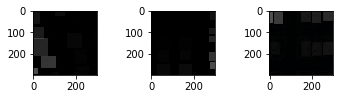

In [6]:
# plot first few images
for i in range(3): #We will be plotting 3 images
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel dat
    image = train_set.load_image(i)
    plt.imshow(image) #First display images
    # plot all masks
    mask, _ = train_set.load_mask(i) #Get the size of the masks
    for j in range(mask.shape[2]): #mask.shape[2], identifies the total identified objects in an image 
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
plt.show()

In [7]:
#Display info about all the images in the training set
for image_id in train_set.image_ids: #Iterate for all the images in the training set
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info) #Gives info of the image ID, the data Source, image path, annotation file path

{'id': '00001', 'source': 'dataset', 'path': 'building\\images\\00001.jpg', 'annotation': 'building\\annots\\00001.xml'}
{'id': '00002', 'source': 'dataset', 'path': 'building\\images\\00002.jpg', 'annotation': 'building\\annots\\00002.xml'}
{'id': '00003', 'source': 'dataset', 'path': 'building\\images\\00003.jpg', 'annotation': 'building\\annots\\00003.xml'}
{'id': '00004', 'source': 'dataset', 'path': 'building\\images\\00004.jpg', 'annotation': 'building\\annots\\00004.xml'}
{'id': '00005', 'source': 'dataset', 'path': 'building\\images\\00005.jpg', 'annotation': 'building\\annots\\00005.xml'}
{'id': '00006', 'source': 'dataset', 'path': 'building\\images\\00006.jpg', 'annotation': 'building\\annots\\00006.xml'}
{'id': '00007', 'source': 'dataset', 'path': 'building\\images\\00007.jpg', 'annotation': 'building\\annots\\00007.xml'}
{'id': '00008', 'source': 'dataset', 'path': 'building\\images\\00008.jpg', 'annotation': 'building\\annots\\00008.xml'}
{'id': '00009', 'source': 'datas

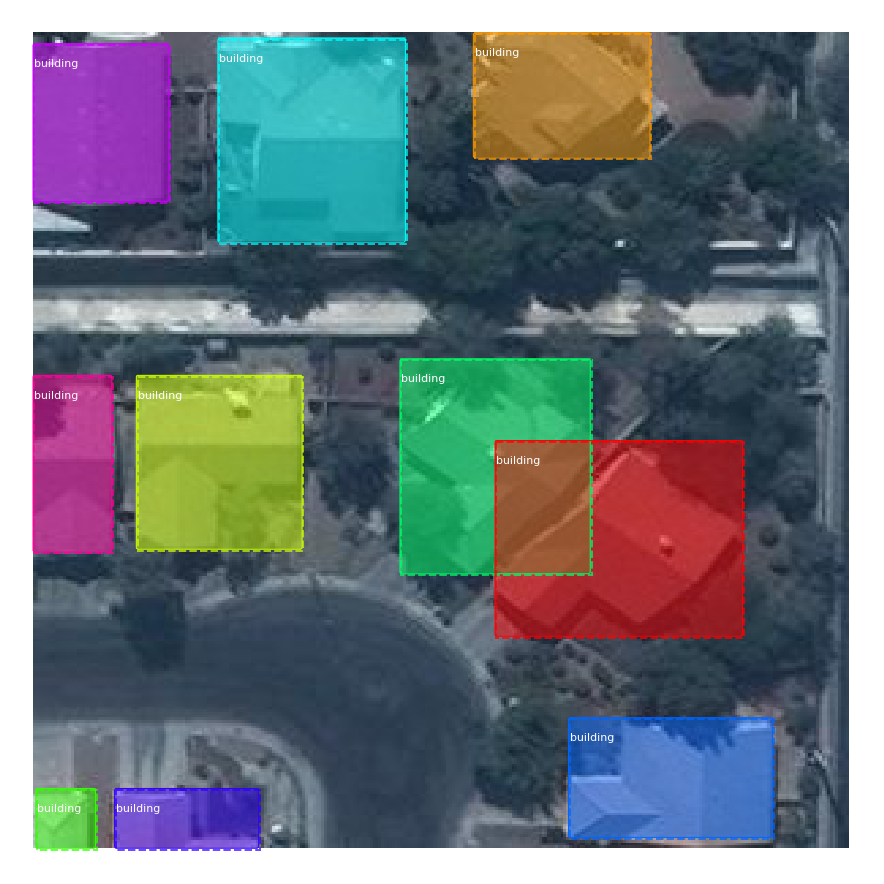

In [8]:
#This function is a part of the MRCNN, viusalize tool that will show a photograph with bounding boxes, masks, and class labels.
from mrcnn.visualize import display_instances
#To use the above function we will extract the bounding boxes from the below function
from mrcnn.utils import extract_bboxes
# define an image id
image_id = 21
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Training the Model

To train the model we will use Transfer Learning: Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. The Mask R-CNN model pre-fit on the MS COCO object detection dataset can be used as a starting point and then tailored to the specific dataset.

In [9]:
#Create the Model
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
# define a configuration for the model
class buildingConfig(Config):
    # define the name of the configuration
    NAME = "building_cfg"
    # number of classes (background + building)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 90
# prepare config
config = buildingConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.keras_model.metrics_tensors = []

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
#Training the model
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=8, layers='heads')
model.keras_model.metrics_tensors = []

I had preciously trained the model and generated the weights, this file is already present in my github page "mask_rcnn_building_cfg_0008.h5".

# Evaluate the Performance of the Model

1 - The performance of a model for an object recognition task is often evaluated using the mean absolute precision, or mAP.

2 - We are predicting bounding boxes so we can determine whether a bounding box prediction is good or not based on how well the predicted and actual bounding boxes overlap. This can be calculated by dividing the area of the overlap by the total area of both bounding boxes, or the intersection divided by the union, referred to as “intersection over union,” or IoU. A perfect bounding box prediction will have an IoU of 1.

3 - Precision refers to the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all bounding boxes predicted.

4 - Recall is the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all objects in the photo. 

5 - As we make more predictions, the recall percentage will increase, but precision will drop or become erratic as we start making false positive predictions. The recall (x) can be plotted against the precision (y) for each number of predictions to create a curve or line. We can maximize the value of each point on this line and calculate the average value of the precision or AP for each value of recall.

6 - The average or mean of the average precision (AP) across all of the images in a dataset is called the mean average precision, or mAP.

7 - The mask-rcnn library provides a mrcnn.utils.compute_ap to calculate the AP and other metrics for a given images. These AP scores can be collected across a dataset and the mean calculated to give an idea at how good the model is at detecting objects in a dataset.

In [10]:
# evaluate the mask rcnn model on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "building_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_building_cfg_0008.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)



Instructions for updating:
Use `tf.cast` instead.


Train mAP: 0.439
Test mAP: 0.439


In [11]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=2):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

# load model weights
model.load_weights('mask_rcnn_building_cfg_0008.h5', by_name=True)

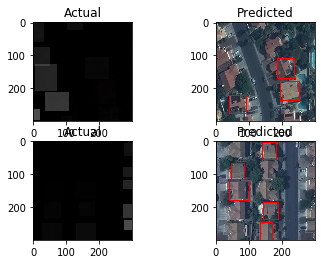

In [12]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)

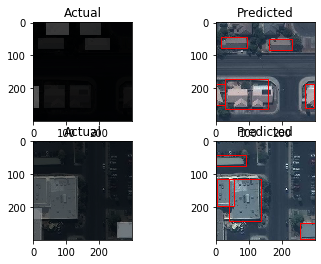

In [13]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

# Conclusion and Learning:

In this project we have learnt the approach to build a Mask RCNN to identify buildings using Satellite map data, the accuracy is not very high, the reason for this can be as below:

1 - A total of 89 images has been used for training.
2 - The choice of using a bounding box around the object is wrong, the shapes of the buildings vary from one another, this variation is very high, hence we can use free flowing lines to describe the boundaries of the building, in this way the boundary for the building is clearly identified, this will improve the accuracy to a great extent.

The approach of using a bounding box to identify objects is more suitable for the following types of projects:
1 - Identification of animals in an image.
2 - Identification of cars, objects, traffic signals, etc in a Advanced Driver Assistance System.
3 - Identification of rotten tomatoes in a heap of tomatoes.

# Future Work

Currently I am searching for a video of satellite map data, so that I must be able to identify buildings from a video.
In the next update of the project, I am going to implement the changes mentioned in 'Conclusion and Learning section', also compare the accuracy of Mask RCNN with You Look Only Once algorithm (YOLO algorithm)